# Automated Secondary Decisioning Checks 

The objective of this notebook will be automate secondary eligibility and affordability checks independent of primary systems. 

The first section of the notebook automates parsing of third party data from Onfido (Identity Checks) and Truelayer (accesses applicants bank data via Open Banking Legislation and API). 

Once the data has been parsed and formatted, eligibility and affordability checks are run on the data, determining a succesful or unsuccesful application.   

The notebook concludes with a simple visualisation of applicant financial transactional data over time. 

NOTE: The data in this notebook is DUMMY data and does not correspond to a real life applicant.

### Required Inputs from Notebook user
#### The three variables below will have to be manually inputted by the notebook user to conduct secondary checks - NOTE: the format must be the same!

In [1]:
application_ID = 'APP2390249249'
end_of_pull = '2020:10:05'
loan = 5000

In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)  
pd.options.display.float_format = '{:.2f}'.format 

#this keeps all numbers to 2 decimal places (only when displayed)

# Onfido

In [3]:
with open('Desktop/Check_creation_Onfido') as f:  
    onfido = list(f)
    
#import raw onfido response

In [4]:
onfido = str(onfido)

#convert to string for parsing

In [5]:
start = onfido.find("adverse_media")

#find the start of relevant substring

In [6]:
end = onfido.find("version") 

#find the end of relevant substring

In [7]:
onfido = onfido[start:end]

#select substring - note adverse and version should appear in all responses to this
#approach should work consistently with all onfido responses - this will be checked for sure

In [8]:
onfido = onfido.split(",") 

#split for easier parsing

In [9]:
for i in onfido:                       
    if '"result":"unidentified"' in i:  
        print("Failed check and result:", i)
        
#must find all other possibilities other than unidentified

Failed check and result: "voting_register":{"result":"unidentified"


### Facial Similarity Check

In [10]:
facial_similarity_score = onfido[31]  

#here I am selecting the object in which the facial similarity score is stored

In [11]:
facial_similarity_score = float(facial_similarity_score[22:28]) 

#selecting the numerical values and changing datatype

In [12]:
if facial_similarity_score < 0.8:    
    print("ERROR: Facial Similarity Failed")
    
#pass threshold to be checked and added  

ERROR: Facial Similarity Failed


# TrueLayer

In [13]:
with open('Desktop/TrueLayer_transList_Response_5') as f:   
    truelayer = list(f)
    
#import truelayer raw truelayer response

In [14]:
truelayer = str(truelayer) 

#convert to string for parsing

In [15]:
truelayer = truelayer[14:-27]   #select relevant substring - note the start and end will remain constant so this
                                #approach should work consistently with truelayer responses with different string lengths
                                #this will of course be checked

In [16]:
truelayer = str(truelayer) #I have had to reconvert to string for some reason here - this allows parsing later on

In [17]:
truelayer = truelayer.split("timestamp") #splitting the string into a list of variables each containing a transaction

In [18]:
del truelayer[0] #this is deleting the first object which is created - don't worry it's not a transaction

In [19]:
income = [] #creating a list, a sort of folder, which will store all income transactions
expenses = [] #creating a list which will store all expense transactions
for i in truelayer:
    index = i.find("amount")
    second_index = index + 8
    if i[second_index] is not "-":
        income.append(i)
    else:
        expenses.append(i)         #what is happening here is an iteration over all variables ie all transactions, and
                                   #where amount is negative - it is stored in expenses list and where it is positive -
                                   #it is stored in the income list

In [20]:
discretionary_expenses = []  #creating a list which will store discretionary expenses
non_discretionary_expenses = [] #creating a list which will store non discretionary expenses

for i in expenses:                       #here we iterate over all the objects/variables in the expenses list to then
    if "Entertainment" in i:            #store in the non discretionary and discretionary lists - as per our decisioning rules
        discretionary_expenses.append(i)
    
    elif "Coffee" in i:
        discretionary_expenses.append(i)

    elif "Books" in i:
        discretionary_expenses.append(i)
    
    elif "Hobbies" in i:
        discretionary_expenses.append(i)
    
    elif "Gambling" in i:
        discretionary_expenses.append(i)
    
    elif "Bars" in i:
        discretionary_expenses.append(i)
    
    elif "Investments" in i:
        discretionary_expenses.append(i)
    
    elif "Gifts" in i:
        discretionary_expenses.append(i)
    
    else:
        non_discretionary_expenses.append(i)

    

In [21]:
print("Total Transactions:", len(truelayer))

#total transactions - not this has been checked with raw response so none are being lost 

Total Transactions: 383


In [22]:
if len(income) + len(expenses) != len(truelayer):
    print("Parsing error - transactions lost")
else:
    print('Parsing successful!')
    
#checking no transactions have been lost in parsing

Parsing successful!


In [23]:
if len(non_discretionary_expenses) + len(discretionary_expenses) != len(expenses):
    print("Parsing error - transactions lost")
else:
    print('Parsing successful!')

#checking no transactions have been lost in parsing

Parsing successful!


In [24]:
non_discretionary_expenses[1]

#Here is an example of how each item in the list looks

'":"2020-01-15T00:00:00+00:00","description":"SAVE THE CHANGE","transaction_type":"DEBIT","transaction_category":"BILL_PAYMENT","transaction_classification":[],"amount":-0.55,"currency":"GBP","transaction_id":"e9acd603b4fcd03df107e44d7b065099","running_balance":{"currency":"GBP","amount":384.98},"meta":{"provider_transaction_category":"BP"}},{"'

# Non-Discretionary Expenses

In [25]:
non_discretionary_dates = []
for i in non_discretionary_expenses:
    i = i[3:13]
    non_discretionary_dates.append(i)
    
#extracting date data and storing into a list

In [26]:
non_discretionary_amounts = []
for i in non_discretionary_expenses:
    index_amount_start = i.find("amount")
    index_amount_start = index_amount_start + 8
    index_amount_end = i.find("currency")
    index_amount_end = index_amount_end - 2
    i = i[index_amount_start:index_amount_end]
    non_discretionary_amounts.append(i)
    
#extracting transaction amount data and storing into a list

In [27]:
non_discretionary_data = [non_discretionary_dates, non_discretionary_amounts]

#combining date list and transaction amount list
#NOTE: the order is being maintained to date will always match the correct transaction

In [28]:
non_discretionary_data = pd.DataFrame(non_discretionary_data)

#formatting data into a DataFrame - (a table)

In [29]:
non_discretionary_data = non_discretionary_data.T

#changing layout of table so that it is vertical rather than horizontal 

In [30]:
non_discretionary_data[0] = pd.to_datetime(non_discretionary_data[0])

#changing datatype to date

In [31]:
non_discretionary_data[1] = pd.to_numeric(non_discretionary_data[1], downcast="float")

#changing datatype to numeric

In [32]:
non_discretionary_data = non_discretionary_data.iloc[::-1]

#reverse to descending order - so the earliest date is first and the latest date is last

In [33]:
non_discretionary_data.index = non_discretionary_data[0]

#here I am setting the data column as the index of the table

In [34]:
non_discretionary_data = non_discretionary_data.resample('M').sum()

#this is an important step: here I group and sum transactions by month

# Discretionary Expenses

In [35]:
discretionary_dates = []
for i in discretionary_expenses:
    i = i[3:13]
    discretionary_dates.append(i)
    
#extracting date data and storing into a list

In [36]:
discretionary_amounts = []
for i in discretionary_expenses:
    index_amount_start = i.find("amount")
    index_amount_start = index_amount_start + 8
    index_amount_end = i.find("currency")
    index_amount_end = index_amount_end - 2
    i = i[index_amount_start:index_amount_end]
    discretionary_amounts.append(i)
    
#extracting transaction amount data and storing into a list

In [37]:
discretionary_data = [discretionary_dates, discretionary_amounts]

#combining date list and transaction amount list
#NOTE: the order is being maintained to date will always match the correct transaction

In [38]:
discretionary_data = pd.DataFrame(discretionary_data)

#formatting data into a DataFrame - (a table)

In [39]:
discretionary_data = discretionary_data.T

#changing layout of table so that it is vertical rather than horizontal 

In [40]:
discretionary_data[0] = pd.to_datetime(discretionary_data[0])

#changing datatype to date

In [41]:
discretionary_data[1] = pd.to_numeric(discretionary_data[1], downcast="float")

#changing datatype to numeric

In [42]:
discretionary_data = discretionary_data.iloc[::-1]

#reverse to descending order - so the earliest date is first and the latest date is last

In [43]:
discretionary_data.index = discretionary_data[0]

#here I am setting the data column as the index of the table

In [44]:
discretionary_data = discretionary_data.resample('M').sum()

#this is an important step: here I group and sum transactions by month

# Income

In [45]:
income_dates = []
for i in income:
    i = i[3:13]
    income_dates.append(i)

#extracting date data and storing into a list

In [46]:
income_amounts = []
for i in income:
    index_amount_start = i.find("amount")
    index_amount_start = index_amount_start + 8
    index_amount_end = i.find("currency")
    index_amount_end = index_amount_end - 2
    i = i[index_amount_start:index_amount_end]
    income_amounts.append(i)
    
#extracting transaction amount data and storing into a list

In [47]:
income_data = [income_dates, income_amounts]

#combining date list and transaction amount list
#NOTE: the order is being maintained to date will always match the correct transaction

In [48]:
income_data = pd.DataFrame(income_data)

#formatting data into a DataFrame - (a table)

In [49]:
income_data = income_data.T

#changing layout of table so that it is vertical rather than horizontal 

In [50]:
income_data[0] = pd.to_datetime(income_data[0])

#changing datatype to date

In [51]:
income_data[1] = pd.to_numeric(income_data[1], downcast="float")

#changing datatype to numeric

In [52]:
income_data = income_data.iloc[::-1] 

#reverse to descending order - so the earliest date is first and the latest date is last

In [53]:
income_data.index = income_data[0]

#here I am setting the data column as the index of the table

In [54]:
income_data = income_data.resample('M').sum()

#this is an important step: here I group and sum transactions by month

## Creating an 'All Months' table - containing all months regardless of number of days of data

In [55]:
discretionary_data = discretionary_data.rename(columns = {1:'Discretionary Expenses (GBP)'})
non_discretionary_data = non_discretionary_data.rename(columns = {1:'Non-Discretionary Expenses (GBP)'})
income_data = income_data.rename(columns = {1:'Income (GBP)'})

#here I am labeling transaction columns in the respective tables 

In [56]:
all_months = pd.concat([income_data, non_discretionary_data, discretionary_data], axis=1, sort=False)

#joining the three data sets into one table

In [57]:
all_months = all_months.fillna(0)

#if there are no transactions in a column for a particular months, pandas stores
#this as a null value - however in reality this represents a zero - so here I am
#changing any null values to zero 

In [58]:
all_months['Monthly Surplus (GBP)'] = (all_months['Income (GBP)'] + all_months['Non-Discretionary Expenses (GBP)']
                                 + all_months['Discretionary Expenses (GBP)'])

## Creating a 'Full Months' table - months with 26 or more days of data

In [59]:
start_of_pull = truelayer[-1]  
start_of_pull = start_of_pull[3:13]

#here I am locating the first transaction in the raw data and extracting the date of the transaction

In [60]:
if start_of_pull[8:10] is not '01' or '02' or '31' or '30' :
    income_data = income_data[1:]
    discretionary_data = discretionary_data[1:]
    non_discretionary_data = non_discretionary_data[1:]

else:
    pass

#here I am saying: if the start of the pull (which will be the earliest transaction date in the file) is not
#either on the 1,2,31,02 of the month or 28 and 29 for February - then this first month is dropped from the data

In [61]:
if end_of_pull[8:10] is not '31' or '30' or '01' or '02' or end_of_pull[5:10] is '02:28'or '02:29':
    income_data = income_data.head(-1)
    discretionary_data = discretionary_data.head(-1)
    non_discretionary_data = non_discretionary_data.head(-1)

else:
    pass



#here I am saying: if the end of the pull, (which will be the date of the application) is not either on the 1,2,31,02
#of the month or 28 and 29 for February - then this last month is dropped from the data
#NOTE: end_of_pull is to be inputted/saved as a variable at the top of the notebook - I have left an explanation there

In [62]:
full_months = pd.concat([income_data, non_discretionary_data, discretionary_data], axis=1, sort=False) 

#joining the three data sets into one table

In [63]:
full_months = full_months.fillna(0) 

#if there are no transactions in a column for a particular months, pandas stores
#this as a null value - however in reality this represents a zero - so here I am
#changing any null values to zero 

In [64]:
full_months['Monthly Surplus (GBP)'] = (full_months['Income (GBP)'] + full_months['Non-Discretionary Expenses (GBP)']
                                 + full_months['Discretionary Expenses (GBP)'])

#here I am creating a new column which will show surplus for each month

In [65]:
full_months.index.name = 'Month' 
all_months.index.name = 'Month'

#Giving a name to the index - which represents month

# True Layer Outputs/Decisioning 

In [66]:
all_months  #This table shows all months from the original TrueLayer pull

,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Month,,,,
2019-10-31,1468.92,-1156.47,-35.00,277.45
2019-11-30,3123.24,-2822.75,-300.49,0.00
2019-12-31,3123.24,-2822.75,-300.49,0.00
2020-01-31,1434.51,-1586.55,-265.49,-417.53


In [67]:
full_months #This table shows all FULL months from the original TrueLayer pull
            #Full is defined as starting and ending on either 30,31,1,2 of the month or 28,29 for February

,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Month,,,,
2019-11-30,3123.24,-2822.75,-300.49,0.00
2019-12-31,3123.24,-2822.75,-300.49,0.00


### NOTE: All calculations are made from the full_months table containing months for which we have at least 26 days worth of data

In [68]:
full_income = full_months['Income (GBP)'].sum()
print('Total Income is', full_income, 'GBP')

Total Income is 6246.48 GBP


In [69]:
disc = full_months['Discretionary Expenses (GBP)'].sum()
print('Total Discretionary Expenses are', disc, 'GBP')

Total Discretionary Expenses are -600.98 GBP


In [70]:
non_disc = full_months['Non-Discretionary Expenses (GBP)'].sum()
print('Total Non-Discretionary Expenses are', non_disc, 'GBP')

Total Non-Discretionary Expenses are -5645.5 GBP


In [71]:
total_expenses = full_months['Discretionary Expenses (GBP)'].sum() + full_months['Non-Discretionary Expenses (GBP)'].sum()
print('Total Expenses are', total_expenses, 'GBP')

Total Expenses are -6246.48 GBP


In [72]:
monthly_surplus = full_months['Monthly Surplus (GBP)'].mean()
print('Monthly surplus is', monthly_surplus, "GBP")

Monthly surplus is 0.0 GBP


In [73]:
credit_limit = full_months['Monthly Surplus (GBP)'].mean() * 10
if credit_limit > 250:
    print('credit limit for', application_ID, 'is', credit_limit, 'GBP')
else:
    print("APPLICATION DECLINED: Affordability checks failed as Credit Limit is below £250")

APPLICATION DECLINED: Affordability checks failed as Credit Limit is below £250


In [74]:
if credit_limit < loan:
    print("APPLICATION DECLINED: Credit Limit is less than size of Loan")

APPLICATION DECLINED: Credit Limit is less than size of Loan


In [75]:
if credit_limit > 250:
    print('Maximum monthly repayment is', monthly_surplus)
else:
    print('NO MAX MONTHLY REPAYMENT AS APPLICATIOND DECLINED')

NO MAX MONTHLY REPAYMENT AS APPLICATIOND DECLINED


# Automated Decisioning from SalesForce Report

This section of the notebook runs secondary decisioning checks with some reliance on the primary systems with regard to parsing - however the checks themselves are run indepedently. 

In [76]:
colnames=['Application ID', 'TrueLayer Junction', 'Transaction Account', 'Bank Account', 'Transaction Type',
         'Transaction Category', 'Amount', 'Description', 'Sub-Category', 'Transaction Classification',
          'Merchant Name', 'Timestamp']
report_original = pd.read_excel(r'Desktop/TrueLayer Transactions List Report-2020-03-25-16-45-06.xlsx',
                       usecols = [1,4,7,8,12,13,14,15,16,19,20,21], names = colnames)

#import data from Salesforce

In [77]:
report_original = report_original[11:-2]  #remove uneeded rows leaving only data columns

In [78]:
list_of_accounts = []
print('List of Accounts in the pull:')
for i in report_original["Bank Account"].unique():
    print(i)
    list_of_accounts.append(i)
    
#print list of bank accounts we have data on for applicant in question

List of Accounts in the pull:
BA INFO - 003634
BA INFO - 003636
BA INFO - 003637


In [79]:
report = [pd.DataFrame(y) for x, y in report_original.groupby('Bank Account', as_index=False)]

#groupby bank account

In [80]:
disc_list = ['Gambling,Lottery', 'Gambling,Casino', 'Gambling,Betting', 'Investments,Bonds', 'Investments,Equities', 
'Gifts & Donations,Charity', 'Gifts & Donations,Gifts', 'Food & Dining,Coffee shops', 'Food & Dining,Bars'
'Shopping,Hobbies', 'Shopping,Books', 'Entertainment,Social Club', 'Entertainment,Movies & DVDs',
'Entertainment,Dating', 'Entertainment,Music', 'Entertainment,Arts', 'Entertainment,Games', 'Entertainment']

#listing all results in transaction classification that should result in transaction being placed in
#discretionary expenses list as per classification criteria

### The cell below iterates over the list of transaction accounts and assigning all transactions to Income, Non-Discretionary and Discretionary 'buckets'.

In [81]:
accounts = []
for i in report:
    Income = i[i['Amount'] > 0]          
    Expenses = i[i['Amount'] < 0]
    
    #split each transaction account into income and expenses  
    
    discretionary = Expenses.loc[Expenses['Transaction Classification'].isin(disc_list)]      
    non_discretionary = Expenses.loc[~Expenses['Transaction Classification'].isin(disc_list)]
            
    #split expenses transactions for each transaction account into discretionary and non-discretionary

    Income['Timestamp'] = pd.to_datetime(Income['Timestamp'])
    non_discretionary['Timestamp'] = pd.to_datetime(non_discretionary['Timestamp'])
    discretionary['Timestamp'] = pd.to_datetime(discretionary['Timestamp'])
    
    #change timestamp column to datetime
    
    Income = Income[["Timestamp", "Amount"]]
    Income.index = Income["Timestamp"]
    
    #select only relevant columns containing date and amount
    
    non_discretionary = non_discretionary[["Timestamp", "Amount"]]
    non_discretionary.index = non_discretionary["Timestamp"]
    
    #select only relevant columns containing date and amount
    
    discretionary = discretionary[["Timestamp", "Amount"]]
    discretionary.index = discretionary["Timestamp"]
    
    #select only relevant columns containing date and amount
    
    discretionary = discretionary.rename(columns = {'Amount':'Discretionary Expenses (GBP)'})
    non_discretionary = non_discretionary.rename(columns = {'Amount':'Non-Discretionary Expenses (GBP)'})
    Income = Income.rename(columns = {'Amount':'Income (GBP)'})

    #rename amount columns
    
    Income = Income.resample('M').sum()
    non_discretionary = non_discretionary.resample('M').sum()
    discretionary = discretionary.resample('M').sum()
    
    #resampling and sum on the month - this is like a groupby - so we get sum of income etc for each month
    #NOTE:the first and last months are likely to be incomplete as this is based on calendar month
   
    
    full_data_set = pd.concat([Income, non_discretionary, discretionary], axis=1, sort=False)
    
    #join the three tables together 
    
    full_data_set['Monthly Surplus (GBP)'] = (full_data_set['Income (GBP)'] + full_data_set['Non-Discretionary Expenses (GBP)']
    + full_data_set['Discretionary Expenses (GBP)'])
    
    #calculate Monthly Surplus

    
    accounts.append(full_data_set)
    
    #accounts will contain the list of tables the above code has created

In [82]:
from IPython.display import display, HTML    

CSS = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(CSS))

#this step is to be able to display all three tables at once 

In [83]:
x = 0
for i in accounts:
    print(list_of_accounts[x])
    display(i)
    x = x + 1
    
#Display Monthly Income, Non-Discretionary Expenses, Discretionary Expenses and Monthly Surplus for each Account

BA INFO - 003634


,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Timestamp,,,,
2019-12-31 00:00:00+00:00,651.37,-472.98,-10.50,167.89
2020-01-31 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-02-29 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-03-31 00:00:00+00:00,1654.32,-1901.28,-35.49,-282.45


BA INFO - 003636


,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Timestamp,,,,
2019-12-31 00:00:00+00:00,651.37,-472.98,-10.50,167.89
2020-01-31 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-02-29 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-03-31 00:00:00+00:00,1654.32,-1901.28,-35.49,-282.45


BA INFO - 003637


,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Timestamp,,,,
2019-12-31 00:00:00+00:00,651.37,-472.98,-10.50,167.89
2020-01-31 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-02-29 00:00:00+00:00,3123.24,-3077.25,-45.99,-0.00
2020-03-31 00:00:00+00:00,1654.32,-1901.28,-35.49,-282.45


In [84]:
x = 0
for i in accounts:
    
    print(list_of_accounts[x])
    
    x = x + 1
    
    full_income = i['Income (GBP)'].sum()
    print('Total Income is', format(full_income, '.2f'), 'GBP')
    
    
    total_expenses = i['Discretionary Expenses (GBP)'].sum() + i['Non-Discretionary Expenses (GBP)'].sum()
    print('Total Expenses are', format(total_expenses, '.2f'), 'GBP')
    
    
    disc = i['Discretionary Expenses (GBP)'].sum()
    print('Total Discretionary Expenses are', format(disc, '.2f'), 'GBP')
    
    
    non_disc = i['Non-Discretionary Expenses (GBP)'].sum()
    print('Total Non-Discretionary Expenses are', format(non_disc, '.2f'), 'GBP')
    
   
    monthly_surplus = i['Monthly Surplus (GBP)'].mean()
    print('Average Monthly surplus is', format(monthly_surplus, '.2f'), "GBP")
    
    print("\n")
    


BA INFO - 003634
Total Income is 8552.17 GBP
Total Expenses are -8666.73 GBP
Total Discretionary Expenses are -137.97 GBP
Total Non-Discretionary Expenses are -8528.76 GBP
Average Monthly surplus is -28.64 GBP


BA INFO - 003636
Total Income is 8552.17 GBP
Total Expenses are -8666.73 GBP
Total Discretionary Expenses are -137.97 GBP
Total Non-Discretionary Expenses are -8528.76 GBP
Average Monthly surplus is -28.64 GBP


BA INFO - 003637
Total Income is 8552.17 GBP
Total Expenses are -8666.73 GBP
Total Discretionary Expenses are -137.97 GBP
Total Non-Discretionary Expenses are -8528.76 GBP
Average Monthly surplus is -28.64 GBP




In [85]:
all_accounts = sum(accounts)
all_accounts

#Display Monthly Income, Non-Discretionary Expenses, Discretionary Expenses and Monthly Surplus for sum of all accounts

,Income (GBP),Non-Discretionary Expenses (GBP),Discretionary Expenses (GBP),Monthly Surplus (GBP)
Timestamp,,,,
2019-12-31 00:00:00+00:00,1954.11,-1418.94,-31.50,503.67
2020-01-31 00:00:00+00:00,9369.72,-9231.75,-137.97,-0.00
2020-02-29 00:00:00+00:00,9369.72,-9231.75,-137.97,-0.00
2020-03-31 00:00:00+00:00,4962.96,-5703.84,-106.47,-847.35


In [86]:
credit_limit = all_accounts['Monthly Surplus (GBP)'].mean() * 10
if credit_limit > 250:
    print('credit limit for', application_ID, 'is', credit_limit, 'GBP')
else:
    print("APPLICATION DECLINED: Affordability checks failed as Credit Limit is below £250")

APPLICATION DECLINED: Affordability checks failed as Credit Limit is below £250


In [87]:
if credit_limit < loan:
    print("APPLICATION DECLINED: Credit Limit is less than size of Loan")

APPLICATION DECLINED: Credit Limit is less than size of Loan


In [88]:
if credit_limit > 250:
    print('Maximum monthly repayment is', monthly_surplus)
else:
    print('NO MAX MONTHLY REPAYMENT AS APPLICATIOND DECLINED')

NO MAX MONTHLY REPAYMENT AS APPLICATIOND DECLINED


# Visualising Trends in Applicant's Spending and Income (ALL ACCOUNTS)

1. Determine applicant's Payday 
2. Determine Bill Payments and Rent
3. Ascertain any third party dependencies - regular transfer to family member for example

In [89]:
import matplotlib.pyplot as plt

In [90]:
report_original = report_original[['Transaction Category', 'Amount', 'Timestamp']]  #selecting relevant fields

In [91]:
purchase = report_original[report_original['Transaction Category'] == 'PURCHASE'] #splitting table according to transaction category
atm = report_original[report_original['Transaction Category'] == 'ATM']
direct_debit = report_original[report_original['Transaction Category'] == 'DIRECT_DEBIT']
transfer  = report_original[report_original['Transaction Category'] == 'TRANSFER']
credit = report_original[report_original['Transaction Category'] == 'CREDIT']
bill_payment = report_original[report_original['Transaction Category'] == 'BILL_PAYMENT']
cash = report_original[report_original['Transaction Category'] == 'CASH']

In [92]:
category_list = [purchase, atm, direct_debit, transfer, credit, bill_payment, cash] 
for i in category_list:                               #convert to datetime                              
    i['Timestamp'] = pd.to_datetime(i['Timestamp'])
    i['Timestamp'] = i['Timestamp'].dt.tz_convert(None)

In [93]:
cash = cash.drop('Transaction Category', axis=1)       #getting rid of unnecessary column
bill_payment = bill_payment.drop('Transaction Category', axis=1)
credit = credit.drop('Transaction Category', axis=1)
transfer = transfer.drop('Transaction Category', axis=1)
direct_debit = direct_debit.drop('Transaction Category', axis=1)
atm = atm.drop('Transaction Category', axis=1)
purchase = purchase.drop('Transaction Category', axis=1)

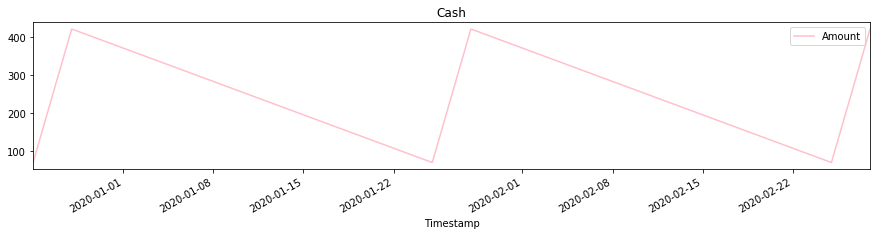

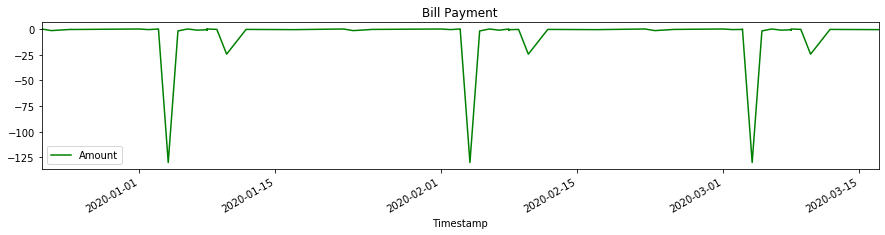

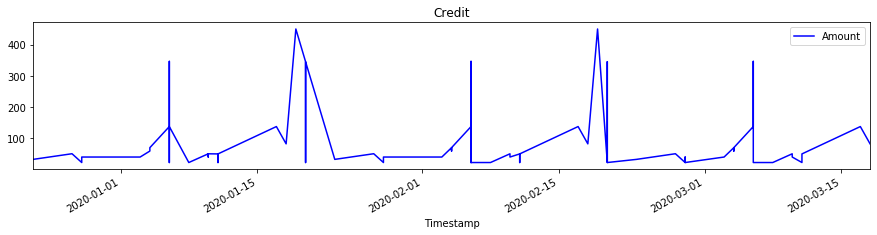

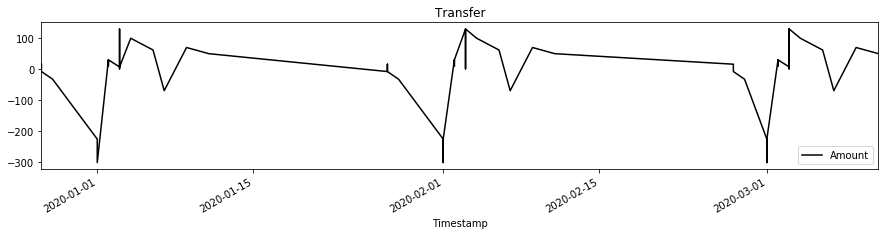

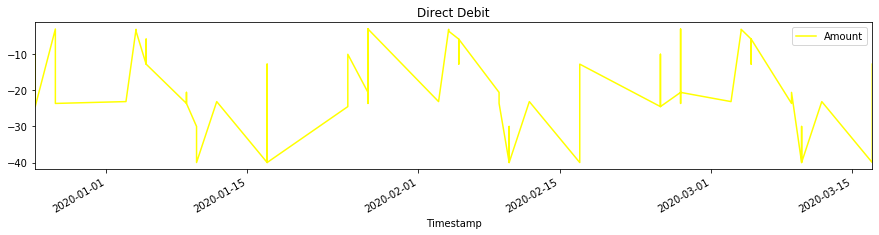

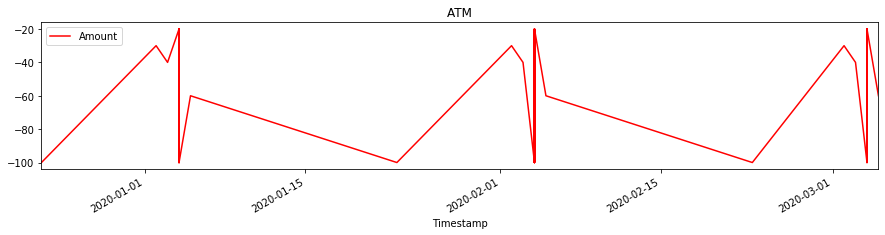

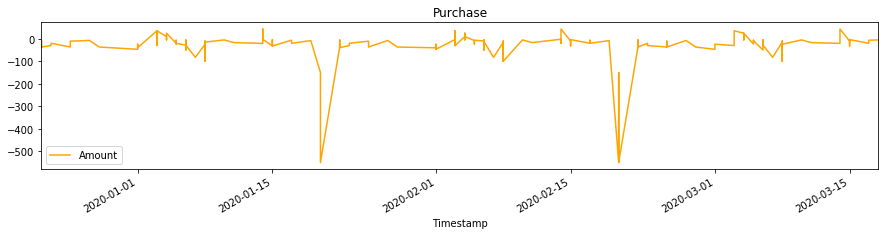

In [94]:
plt.rcParams["figure.figsize"]=15,3  
cash.plot(x='Timestamp', color='pink', title='Cash')
bill_payment.plot(x='Timestamp', color='green', title='Bill Payment')
credit.plot(x='Timestamp', color='blue', title='Credit')
transfer.plot(x='Timestamp', color='black', title='Transfer')
direct_debit.plot(x='Timestamp', color='yellow', title='Direct Debit')
atm.plot(x='Timestamp', color='red', title='ATM')
purchase.plot(x='Timestamp', color='orange', title='Purchase')